Number of GPUs available : 0
x =
 tf.Tensor(
[[-0.9486833-0.3162278j -0.3162278+0.9486833j]
 [ 0.9486833-0.9486833j -0.9486833+0.3162278j]
 [ 0.9486833-0.9486833j -0.3162278-0.9486833j]
 ...
 [-0.3162278+0.3162278j  0.3162278-0.9486833j]
 [-0.3162278+0.9486833j  0.3162278+0.9486833j]
 [ 0.3162278-0.3162278j -0.3162278+0.3162278j]], shape=(1024, 2), dtype=complex64)
h.shape = (1024, 4, 2)
h =
 tf.Tensor(
[[[ 0.23996116-0.8300541j   0.21975602-0.59269774j]
  [-0.536973  -0.8548297j  -0.01548781+0.546876j  ]
  [-0.13982618-0.2781121j   0.35190108+0.6043106j ]
  [ 0.29375517+0.5098129j   0.4249124 -0.7878665j ]]

 [[ 0.8614107 +0.74963117j  1.3904587 -0.11458463j]
  [-0.46925   +0.5711914j   0.11782271+0.28934234j]
  [-0.42109132-0.9668497j  -0.9808323 +0.29091337j]
  [ 0.20630483-0.22149724j -0.33810118-1.4239968j ]]

 [[ 0.45211184+1.0798692j   0.10010465+1.080154j  ]
  [ 0.3108766 -1.0766752j  -0.96575177+0.66092384j]
  [ 0.16536716-0.06865901j -0.7205249 +1.1642604j ]
  [-0.19574766-0.

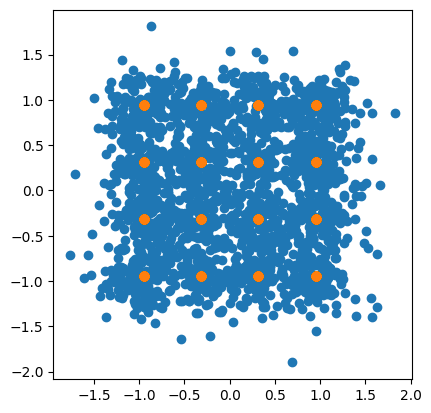

In [5]:
### GPU Configuration and Imports
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

### Import Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder

### Simple Uncoded Transmission
NUM_TX_ANT = 2 # Number of Transmitter Antennas
NUM_RX_ANT = 4 # Number of Receiver Antennas
NUM_BITS_PER_SYMBOL = 4 # 16 QAM
BATCH_SIZE = 1024 # Parallel in 3 batches
qam_source = QAMSource(NUM_BITS_PER_SYMBOL)
x = qam_source([BATCH_SIZE, NUM_TX_ANT])
print('x =\n',x)

### Create `FlatFadingChannel` to simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
channel = FlatFadingChannel(NUM_TX_ANT, NUM_RX_ANT, add_awgn=True, return_channel=True)
no = 0.2 # Noise Variance of the Transmission Channel

# y and h are the Channel Output and Channel Realizations, respectively.
y, h = channel([x, no]) # x = qam_source([batch_size, num_tx_ant]), no = 0.2
print('h.shape =',h.shape)
print('h =\n',h)
print('y.shape =',y.shape)
print('y =\n',y)

s = tf.cast(no*tf.eye(NUM_RX_ANT, NUM_RX_ANT), y.dtype)
x_hat, no_eff = lmmse_equalizer(y, h, s)

plt.axes().set_aspect(1.0)
plt.scatter(np.real(x_hat), np.imag(x_hat));
plt.scatter(np.real(x), np.imag(x));